In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
baslik_font = {'family': 'arial', 'color': 'darkred','weight': 'bold','size': 13 }
eksen_font  = {'family': 'arial', 'color': 'darkblue','weight': 'bold','size': 10 }

In [2]:
df = pd.read_csv('StudentsPerformance.csv')
df.columns = ['cinsiyet', 'koken', 'aile_egt_seviyesi', 'ogle_yemegi', 
                              'hazirlik_kursu', 'matematik_notu', 'okuma_notu', 'yazma_notu']
df.head()

,cinsiyet,koken,aile_egt_seviyesi,ogle_yemegi,hazirlik_kursu,matematik_notu,okuma_notu,yazma_notu
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### 1. Sınav sonuçları normal dağılımlı mıdır? 

Önce sınav sonuçlarıyla ilgili genel bir bakışa sahip olmak için histogramlarına bakalım.

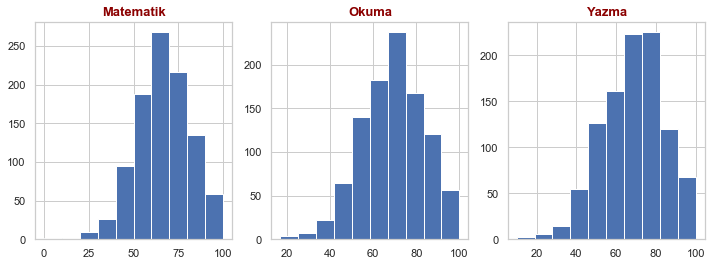

In [3]:
plt.figure(figsize = (12,4))
plt.subplot(1,3,1)
plt.hist(df['matematik_notu'])
plt.title('Matematik', fontdict = baslik_font)
plt.subplot(1,3,2)
plt.hist(df['okuma_notu'])
plt.title('Okuma', fontdict = baslik_font)
plt.subplot(1,3,3)
plt.hist(df['yazma_notu'])
plt.title('Yazma', fontdict = baslik_font)
plt.show()

Hiştogramlarda notların normal dağılıma yakın olduğunu görüyoruz. Daha iyi test etmek için Jarque-Bera ve Normaltest'leri uygulayalım.

In [4]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

# Virgülden sonraki basamakları ayarlayalım.
pd.options.display.float_format = '{:.5f}'.format

dersler = ['matematik_notu', 'okuma_notu', 'yazma_notu']
dagilim_testi = pd.DataFrame(columns = ['dersler', 'JB_stats','JB_pvalue', 'normal_stats', 'normal_pvalue'])

for ders in dersler:
    JB_stats = jarque_bera(df[ders])
    normal_stats = normaltest(df[ders])
    dagilim_testi = dagilim_testi.append({'dersler': ders, 'JB_stats': JB_stats[0], 'JB_pvalue': JB_stats[1],
                                         'normal_stats': normal_stats[0], 'normal_pvalue': normal_stats[1]}, 
                                        ignore_index = True)
dagilim_testi

,dersler,JB_stats,JB_pvalue,normal_stats,normal_pvalue
0,matematik_notu,15.91226,0.00035,15.40896,0.00045
1,okuma_notu,11.38330,0.00337,11.11741,0.00385
2,yazma_notu,13.98509,0.00092,13.60645,0.00111


Yukarıda görüldüğü üzere küçük normal pvalue'lara ulaştık. Bu bize değişkenlerin o kadar da normal dağılmadığını gösterir.
Burada değişkenler üzerinde log dönüşümleri yaparak dağılımı tekrar kontrol edelim.

In [5]:
#?? log dönüşümü yaptıktan sonra
df.head()

,cinsiyet,koken,aile_egt_seviyesi,ogle_yemegi,hazirlik_kursu,matematik_notu,okuma_notu,yazma_notu
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Normalize metodunu kullanarak değişkenleri normalleştirelim.

In [6]:
from sklearn.preprocessing import normalize

df['normalized_mat'] = normalize(np.array(df['matematik_notu']).reshape(1,-1)).reshape(-1,1)
df['normalized_okuma'] = normalize(np.array(df['okuma_notu']).reshape(1,-1)).reshape(-1,1)
df['normalized_yazma'] = normalize(np.array(df['yazma_notu']).reshape(1,-1)).reshape(-1,1)
ozellikler = ['matematik_notu', 'normalized_mat', 'okuma_notu', 'normalized_okuma',
             'yazma_notu', 'normalized_yazma']


print('Karşılaştırmalı min değerler: \n -------')
print(df[ozellikler].min())
print('Karşılaştırmalı maks değerler: \n -------')
print(df[ozellikler].max())

Karşılaştırmalı min değerler: 
 -------
matematik_notu      0.00000
normalized_mat      0.00000
okuma_notu         17.00000
normalized_okuma    0.00760
yazma_notu         10.00000
normalized_yazma    0.00454
dtype: float64
Karşılaştırmalı maks değerler: 
 -------
matematik_notu     100.00000
normalized_mat       0.04664
okuma_notu         100.00000
normalized_okuma     0.04473
yazma_notu         100.00000
normalized_yazma     0.04535
dtype: float64


In [7]:
normaltest(df['normalized_mat'])

NormaltestResult(statistic=15.408960513931847, pvalue=0.00045080293869937283)

In [8]:
df[ozellikler].head()

,matematik_notu,normalized_mat,okuma_notu,normalized_okuma,yazma_notu,normalized_yazma
0,72,0.03358,72,0.03221,74,0.03356
1,69,0.03218,90,0.04026,88,0.03991
2,90,0.04197,95,0.04250,93,0.04218
3,47,0.02192,57,0.02550,44,0.01995
4,76,0.03545,78,0.03489,75,0.03401


Orjinal değişkenleri normalize edilmiş halleriyle kıyasladığımız scatter grafikleri çizelim.

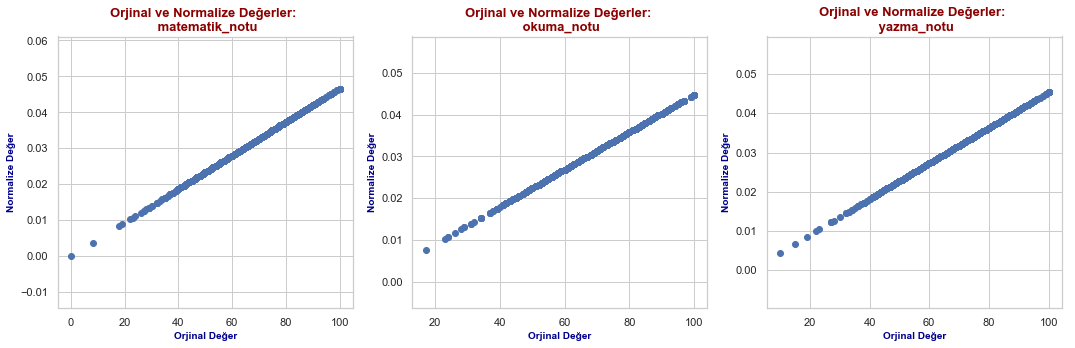

In [9]:
plt.figure(figsize=(18,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(df[ozellikler[2*i]], df[ozellikler[2*i+1]])
    plt.title('Orjinal ve Normalize Değerler: \n {}'.format(ozellikler[2*i]), fontdict = baslik_font)
    plt.xlabel('Orjinal Değer', fontdict = eksen_font)
    plt.ylabel('Normalize Değer', fontdict = eksen_font)
plt.show()

### 2. Üç sınav sonucunu tek bir değişkende hedef değişkeni olarak tutalım.

In [10]:
#pd.options.display.float_format = '{:.2f}'.format
df['ortalama_not'] = (df['matematik_notu'] + df['okuma_notu'] + df['yazma_notu'])/3
df['ortalama_not'].head()

0   72.66667
1   82.33333
2   92.66667
3   49.33333
4   76.33333
Name: ortalama_not, dtype: float64

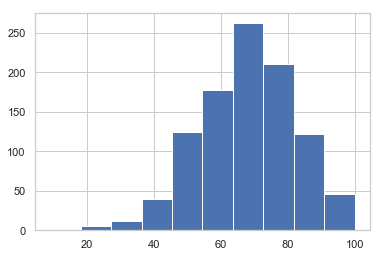

In [11]:
plt.hist(df['ortalama_not'])
plt.show()

In [12]:
normaltest(df['ortalama_not'])

NormaltestResult(statistic=15.186721327231322, pvalue=0.0005037851534494478)

In [13]:
df['logged_ortalama_not'] = np.log(df['ortalama_not'])
df['logged_ortalama_not'].head()

0   4.28588
1   4.41078
2   4.52901
3   3.89860
4   4.33511
Name: logged_ortalama_not, dtype: float64

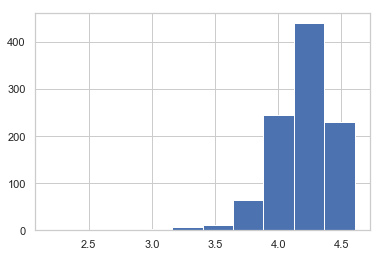

NormaltestResult(statistic=361.8369432975687, pvalue=2.6798228664902956e-79)


In [14]:
plt.hist(df['logged_ortalama_not'])
plt.show()
print(normaltest(df['logged_ortalama_not']))

Normal dağılıp dağılmadığını kontrol edelim.

Log dönüşümü yapılmış ve yapılmamış ortalama not değişkenlerini Q-Q plotlarla inceleyelim.

In [16]:
# ???? Log dönüşümü yapıldığında normal pvalue neden küçülüyor?

### 3. Yeni değişkenimiz hangi değişkenlerle ilişkilidir?

In [17]:
df.corr()

,matematik_notu,okuma_notu,yazma_notu,normalized_mat,normalized_okuma,normalized_yazma,ortalama_not,logged_ortalama_not
matematik_notu,1.00000,0.81758,0.80264,1.00000,0.81758,0.80264,0.91875,0.89910
okuma_notu,0.81758,1.00000,0.95460,0.81758,1.00000,0.95460,0.97033,0.94291
yazma_notu,0.80264,0.95460,1.00000,0.80264,0.95460,1.00000,0.96567,0.94149
normalized_mat,1.00000,0.81758,0.80264,1.00000,0.81758,0.80264,0.91875,0.89910
normalized_okuma,0.81758,1.00000,0.95460,0.81758,1.00000,0.95460,0.97033,0.94291
normalized_yazma,0.80264,0.95460,1.00000,0.80264,0.95460,1.00000,0.96567,0.94149
ortalama_not,0.91875,0.97033,0.96567,0.91875,0.97033,0.96567,1.00000,0.97508
logged_ortalama_not,0.89910,0.94291,0.94149,0.89910,0.94291,0.94149,0.97508,1.00000


Normal olarak ortlama_not değişkenimiz ayrı ayrı ortalamayı oluşturan dersler ile ilişkilidir. Ancak biz diğer değişkenlerle ilişkisine bakalım.

Cinsiyet, köken, aile eğitim seviyesi, öğle yemeği, hazırlık kursu ile ortalama not değişkeninin ilişkisini inceleyeceğiz. 

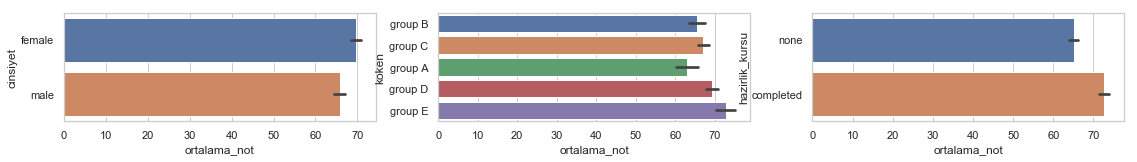

In [52]:
plt.figure(figsize = (19,2))
plt.subplot(1,3,1)
sns.barplot(df['ortalama_not'], df['cinsiyet'])

plt.subplot(1,3,2)
sns.barplot(df['ortalama_not'], df['koken'])

plt.subplot(1,3,3)
sns.barplot(df['ortalama_not'], df['hazirlik_kursu'])
plt.show()


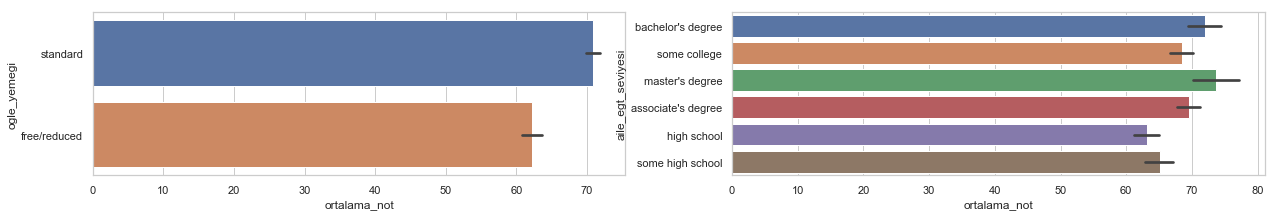

In [53]:
plt.figure(figsize = (21,3))
plt.subplot(1,2,1)
sns.barplot(df['ortalama_not'], df['ogle_yemegi'])

plt.subplot(1,2,2)
sns.barplot(df['ortalama_not'], df['aile_egt_seviyesi'])
plt.show()

Grafiklerde ortalama notların kategorik değişkenlerle bir ilişksi olduğunu anlayabiliriz. Ancak bu farklılıkların istatistiksel olarak anlamlı olup olmadığını kontrol edelim.

In [54]:
df.head()

,cinsiyet,koken,aile_egt_seviyesi,ogle_yemegi,hazirlik_kursu,matematik_notu,okuma_notu,yazma_notu,normalized_mat,normalized_okuma,normalized_yazma,ortalama_not,logged_ortalama_not
0,female,group B,bachelor's degree,standard,none,72,72,74,0.03358,0.03221,0.03356,72.66667,4.28588
1,female,group C,some college,standard,completed,69,90,88,0.03218,0.04026,0.03991,82.33333,4.41078
2,female,group B,master's degree,standard,none,90,95,93,0.04197,0.04250,0.04218,92.66667,4.52901
3,male,group A,associate's degree,free/reduced,none,47,57,44,0.02192,0.02550,0.01995,49.33333,3.89860
4,male,group C,some college,standard,none,76,78,75,0.03545,0.03489,0.03401,76.33333,4.33511


In [64]:
ttest_cinsiyet = stats.ttest_ind(df[df['cinsiyet'] == 'male']['ortalama_not'],
                                df[df['cinsiyet'] == 'female']['ortalama_not'])
ttest_hazirlik = stats.ttest_ind(df[df['hazirlik_kursu'] == 'none']['ortalama_not'],
                                df[df['hazirlik_kursu'] == 'completed']['ortalama_not'])
ttest_yemek = stats.ttest_ind(df[df['ogle_yemegi'] == 'free/reduced']['ortalama_not'],
                                df[df['ogle_yemegi'] == 'standard']['ortalama_not'])

print('T Test Cinsiyet -----', ttest_cinsiyet)
print('T Test Hazırlık Kursu -----', ttest_hazirlik)
print('T Test Öğle Yemeği-----', ttest_yemek)

T Test Cinsiyet ----- Ttest_indResult(statistic=-4.169913529142, pvalue=3.311973638243664e-05)
T Test Hazırlık Kursu ----- Ttest_indResult(statistic=-8.390944443482592, pvalue=1.633780203592351e-16)
T Test Öğle Yemeği----- Ttest_indResult(statistic=-9.575113051511476, pvalue=7.736791812495384e-21)


Yukarıdaki T test sonuçlarında P değerlerinin oldukça küçük olduğunu görüyoruz. Yani bu farklılıklar istatistiksel olarak anlamlıdır. Dolayısıyla bu değişkenleri veri kümemizde tutmamızda fayda var.

In [72]:
kokenler = df['koken'].unique()
tablo = pd.DataFrame(columns = ['grup_1', 'grup_2', 'istatistik', 'p_value'])
for i in range(0, len(kokenler)):
    for j in range(i+1, len(kokenler)):
        ttest = stats.ttest_ind(df[df['koken'] == kokenler[i]]['ortalama_not'], df[df['koken'] == kokenler[j]]['ortalama_not'])
        grup_1 = kokenler[i]
        grup_2 = kokenler[j]
        istatistik = ttest[0]
        p_value  = ttest[1]
        
        tablo = tablo.append({'grup_1': grup_1,
                             'grup_2': grup_2,
                             'istatistik': istatistik,
                             'p_value': p_value}, ignore_index = True )
display(tablo)

,grup_1,grup_2,istatistik,p_value
0,group B,group C,-1.27825,0.20175
1,group B,group A,1.31650,0.18909
2,group B,group D,-2.80311,0.00528
3,group B,group E,-4.46038,0.00001
4,group C,group A,2.46659,0.01405
5,group C,group D,-1.80636,0.07138
6,group C,group E,-3.93587,0.00010
7,group A,group D,-3.71794,0.00023
8,group A,group E,-4.95867,0.00000
9,group D,group E,-2.48705,0.01329


Significance leveli 0.05 olarak kabul edersek ,yukarıdaki tabloda bazı değişkenler arasındaki farklılıkların istatistiksel olarak anlamlı bazılarının ise anlamsız olduğunu görüyoruz.